In [1]:
"""
# XGBoost Regression — NACA 4-Digit Airfoils

**Dataset:** AirfRANS (NACA 4-digit series only — 489 samples)
**Features:** Reynolds number, angle of attack, camber, camber position, thickness
**Target:** Lift-to-Drag ratio (L/D)

XGBoost is an optimized gradient boosting implementation with:
- Regularization (L1 and L2 on leaf weights)
- Second-order gradients (Newton boosting)
- Efficient handling of sparse data

Key hyperparameters:
- **n_estimators:** Number of boosting rounds
- **max_depth:** Maximum tree depth
- **learning_rate:** Shrinkage parameter
- **reg_lambda:** L2 regularization on leaf weights
"""
from __future__ import annotations


from pathlib import Path
import sys


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error


import xgboost as xgb


# ─────────────────────────────────────────────────────────────────────────────
# Setup paths
# ─────────────────────────────────────────────────────────────────────────────
def _find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / 'src').is_dir():
            return p
    raise RuntimeError(f"Could not find repo root from: {start}")


REPO_ROOT = _find_repo_root(Path.cwd())
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))


from src.config import DATA_DIR, RAW_DATASET_DIR
from src.tabular_data import load_airfrans_tabular_split


# ─────────────────────────────────────────────────────────────────────────────
# Load NACA 4-digit dataset
# ─────────────────────────────────────────────────────────────────────────────
csv_path = DATA_DIR / 'airfrans_dataset.csv'
manifest_path = RAW_DATASET_DIR / 'manifest.json'
task = 'full'


train_df, test_df = load_airfrans_tabular_split(csv_path, manifest_path, task=task)

# Clean NACA 4-digit features
feature_cols = ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']
target_col = 'L_D'

FEATURE_LABELS = {
    'Reynolds': 'Reynolds Number',
    'angle_of_attack_rad': 'Angle of Attack (rad)',
    'camber': 'Max Camber (%)',
    'camber_pos': 'Camber Position (tenths)',
    'thickness': 'Thickness (%)',
}


X_train = train_df[feature_cols]
y_train = np.asarray(train_df[target_col]).reshape(-1)
X_test = test_df[feature_cols]
y_test = np.asarray(test_df[target_col]).reshape(-1)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
print(f"Features: {feature_cols}")


# ─────────────────────────────────────────────────────────────────────────────
# Preprocessing and evaluation function
# ─────────────────────────────────────────────────────────────────────────────
pre = Pipeline([('scaler', StandardScaler())])


def fit_eval(n_estimators: int, max_depth: int, learning_rate: float = 0.1, reg_lambda: float = 1.0) -> dict:
    """Train XGBoost with given hyperparameters."""
    model = xgb.XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        reg_lambda=reg_lambda,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42,
        n_jobs=-1,
    )
    pipe = Pipeline([('pre', pre), ('model', model)])
    pipe.fit(X_train, y_train)
    
    y_train_pred = np.asarray(pipe.predict(X_train)).reshape(-1)
    y_test_pred = np.asarray(pipe.predict(X_test)).reshape(-1)
    
    n_train, p = X_train.shape
    n_test = len(y_test)
    
    r2_tr = float(r2_score(y_train, y_train_pred))
    r2_te = float(r2_score(y_test, y_test_pred))
    
    # Adjusted R²
    r2_adj_tr = 1 - (1 - r2_tr) * (n_train - 1) / (n_train - p - 1)
    r2_adj_te = 1 - (1 - r2_te) * (n_test - 1) / (n_test - p - 1)
    
    rmse_te = float(np.sqrt(mean_squared_error(y_test, y_test_pred)))
    
    # Feature importances
    importances = pipe.named_steps['model'].feature_importances_
    
    return {
        'n_estimators': n_estimators,
        'max_depth': max_depth,
        'learning_rate': learning_rate,
        'reg_lambda': reg_lambda,
        'r2_train': r2_tr,
        'r2_test': r2_te,
        'r2_adj_train': r2_adj_tr,
        'r2_adj_test': r2_adj_te,
        'rmse_test': rmse_te,
        'gap': r2_tr - r2_te,
        'importances': importances,
    }

Training samples: 378, Test samples: 111
Features: ['Reynolds', 'angle_of_attack_rad', 'camber', 'camber_pos', 'thickness']


In [2]:
# ─────────────────────────────────────────────────────────────────────────────
# 2D Grid Search: n_estimators × max_depth
# ─────────────────────────────────────────────────────────────────────────────
n_grid = [50, 100, 200, 300, 500]
d_grid = [2, 3, 4, 5, 6, 8]

rows = [fit_eval(n, d, learning_rate=0.1, reg_lambda=1.0) for n in n_grid for d in d_grid]
res = pd.DataFrame(rows)

# Best result
best = res.loc[res['r2_adj_test'].idxmax()]
print(f"\nBest configuration:")
print(f"  n_estimators = {int(best['n_estimators'])}, max_depth = {int(best['max_depth'])}")
print(f"  Train R² adj = {best['r2_adj_train']:.4f}")
print(f"  Test R² adj  = {best['r2_adj_test']:.4f}")
print(f"  RMSE (test)  = {best['rmse_test']:.2f}")
print(f"  Overfit gap  = {best['gap']:.4f}")

res[['n_estimators', 'max_depth', 'r2_adj_train', 'r2_adj_test', 'rmse_test', 'gap']].sort_values('r2_adj_test', ascending=False).head(10)


Best configuration:
  n_estimators = 500, max_depth = 4
  Train R² adj = 1.0000
  Test R² adj  = 0.9642
  RMSE (test)  = 6.25
  Overfit gap  = 0.0342


,n_estimators,max_depth,r2_adj_train,r2_adj_test,rmse_test,gap
26,500,4,0.999974,0.964180,6.250844,0.034165
20,300,4,0.999744,0.963797,6.284190,0.034305
14,200,4,0.999240,0.963403,6.318310,0.034184
27,500,5,0.999999,0.963321,6.325429,0.035012
21,300,5,0.999980,0.963228,6.333380,0.035081
15,200,5,0.999874,0.963180,6.337553,0.035023
9,100,5,0.999306,0.962830,6.367593,0.034795
8,100,4,0.997454,0.962195,6.421787,0.033575
25,500,3,0.999510,0.961492,6.481164,0.036274
28,500,6,1.000000,0.960916,6.529466,0.037307


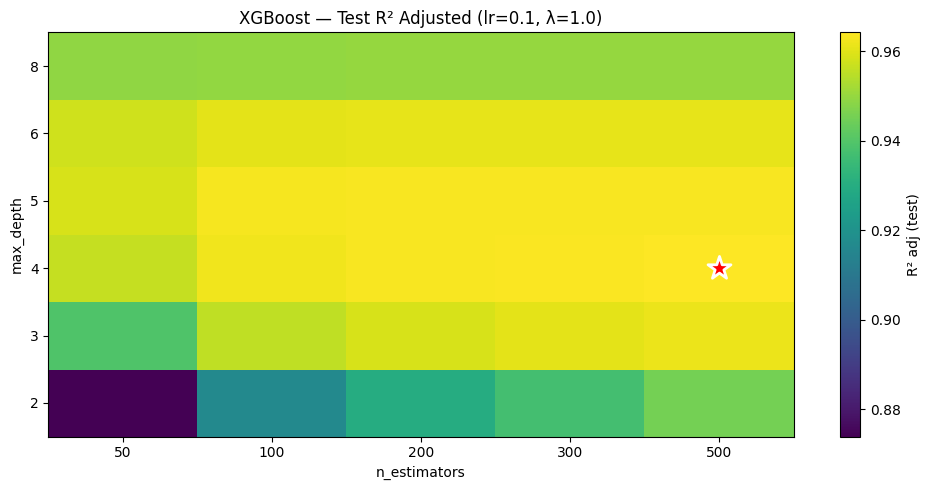


★ Best: n_estimators=500, max_depth=4 → R² = 0.9642


In [3]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 1: Heatmap of Test R² (n_estimators × max_depth)
# ─────────────────────────────────────────────────────────────────────────────
pivot = res.pivot(index='max_depth', columns='n_estimators', values='r2_adj_test')

fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(pivot.values, aspect='auto', cmap='viridis', origin='lower')

ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks(range(len(pivot.columns)))
ax.set_xticklabels(pivot.columns)

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_title('XGBoost — Test R² Adjusted (lr=0.1, λ=1.0)')

# Mark best point
best_row_idx = list(pivot.index).index(best['max_depth'])
best_col_idx = list(pivot.columns).index(best['n_estimators'])
ax.scatter([best_col_idx], [best_row_idx], marker='*', s=300, c='red', edgecolors='white', linewidths=2)

plt.colorbar(im, label='R² adj (test)')
plt.tight_layout()
plt.show()

print(f"\n★ Best: n_estimators={int(best['n_estimators'])}, max_depth={int(best['max_depth'])} → R² = {best['r2_adj_test']:.4f}")

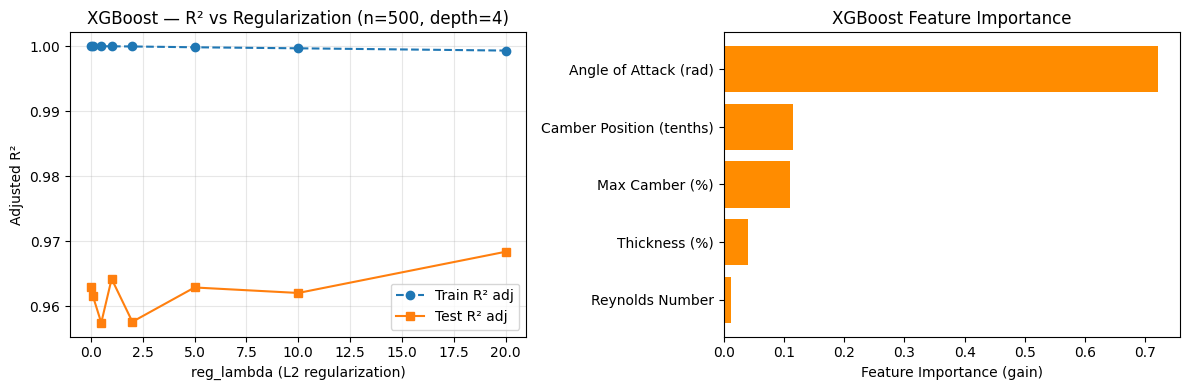

,reg_lambda,r2_adj_train,r2_adj_test,gap
0,0.0,0.999995,0.962929,0.035381
1,0.1,0.999992,0.961503,0.036739
2,0.5,0.999983,0.957426,0.040622
3,1.0,0.999974,0.964180,0.034165
4,2.0,0.999949,0.957574,0.040447
5,5.0,0.999823,0.962856,0.035281
6,10.0,0.999666,0.962011,0.035933
7,20.0,0.999317,0.968353,0.029535


In [4]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 2: Regularization sweep (reg_lambda) at best n_estimators/max_depth
# ─────────────────────────────────────────────────────────────────────────────
best_n = int(best['n_estimators'])
best_d = int(best['max_depth'])

lambdas = [0.0, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0]
rows2 = [fit_eval(best_n, best_d, learning_rate=0.1, reg_lambda=float(l)) for l in lambdas]
res2 = pd.DataFrame(rows2)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Left: reg_lambda vs R²
axes[0].plot(res2['reg_lambda'], res2['r2_adj_train'], 'o--', label='Train R² adj', color='tab:blue')
axes[0].plot(res2['reg_lambda'], res2['r2_adj_test'], 's-', label='Test R² adj', color='tab:orange')
axes[0].set_xlabel('reg_lambda (L2 regularization)')
axes[0].set_ylabel('Adjusted R²')
axes[0].set_title(f'XGBoost — R² vs Regularization (n={best_n}, depth={best_d})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right: Feature importances from best model
best_importances = best['importances']
sorted_idx = np.argsort(best_importances)[::-1]
labels = [FEATURE_LABELS.get(feature_cols[i], feature_cols[i]) for i in sorted_idx]

axes[1].barh(range(len(feature_cols)), best_importances[sorted_idx], color='darkorange')
axes[1].set_yticks(range(len(feature_cols)))
axes[1].set_yticklabels(labels)
axes[1].set_xlabel('Feature Importance (gain)')
axes[1].set_title('XGBoost Feature Importance')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

res2[['reg_lambda', 'r2_adj_train', 'r2_adj_test', 'gap']]

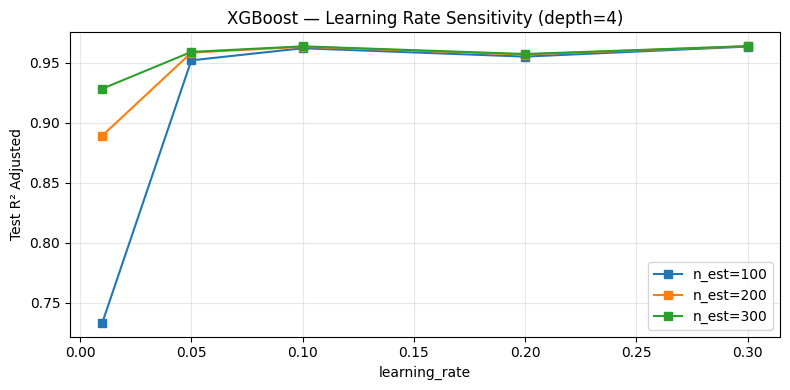

In [5]:
# ─────────────────────────────────────────────────────────────────────────────
# Plot 3: Learning Rate Sensitivity
# ─────────────────────────────────────────────────────────────────────────────
lr_rows = []
for lr in [0.01, 0.05, 0.1, 0.2, 0.3]:
    for n_est in [100, 200, 300]:
        result = fit_eval(n_est, best_d, learning_rate=lr, reg_lambda=1.0)
        lr_rows.append(result)

lr_res = pd.DataFrame(lr_rows)

fig, ax = plt.subplots(figsize=(8, 4))
for n_est in [100, 200, 300]:
    subset = lr_res[lr_res['n_estimators'] == n_est]
    ax.plot(subset['learning_rate'], subset['r2_adj_test'], 's-', label=f'n_est={n_est}')

ax.set_xlabel('learning_rate')
ax.set_ylabel('Test R² Adjusted')
ax.set_title(f'XGBoost — Learning Rate Sensitivity (depth={best_d})')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---

## Conclusions (XGBoost Only)

### Final XGBoost Metrics (Best Observed)
- **Core best (depth/trees sweep):** `max_depth=4`, `n_estimators=500`, `learning_rate=0.1`, `reg_lambda=1.0`
- **Adjusted $R^2$ (train):** $0.999974$
- **Adjusted $R^2$ (test):** $0.964180$
- **Test RMSE:** $6.250844$
- **Overfit gap (train − test):** $0.034165$

### Regularization Note (from your sweep at n=500, depth=4, lr=0.1)
- Best observed point in that sweep: `reg_lambda=20.0`
- **Adjusted $R^2$ (train):** $0.999317$
- **Adjusted $R^2$ (test):** $0.968353$
- **Overfit gap (train − test):** $0.029535$

### Key Deductions
1. **Depth is the main complexity knob.** `max_depth=4` performs best here—deeper trees start to overfit without improving test performance.
2. **XGBoost fits the training set extremely well.** The train $R^2_{adj}$ is near 1.0; the practical goal is minimizing the generalization gap.
3. **Regularization is an effective lever.** Increasing `reg_lambda` improves test $R^2_{adj}$ while reducing the overfit gap in this setup.
4. **Angle of attack dominates the signal.** Your feature-importance plot shows AoA contributes the most gain, consistent with L/D being highly sensitive to AoA compared to geometry/Re effects in this dataset.
